In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install accelerate
import torch
import librosa
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor, TrainingArguments, Trainer, get_scheduler

In [ ]:
model_name = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForAudioClassification.from_pretrained(model_name)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.utils import resample
def collect_audio_files_and_labels(root_dir):
    audio_files = []
    labels = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                full_path = os.path.join(subdir, file)
                audio_files.append(full_path)
                # Label fake as 0 and real as 1 based on filename
                labels.append(0 if 'fake' in file else 1)
    return audio_files, labels

def collect_audio_files_and_labels0(root_dir):
    audio_files = []
    labels = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                full_path = os.path.join(subdir, file)
                audio_files.append(full_path)
                # Label fake as 0 and real as 1 based on filename
                labels.append(0 if 'F' in file else 1)
    return audio_files, labels

def balance_data_by_undersampling(data, labels):
    # 將數據分為偽造和真實音頻
    fake_data = [d for d, label in zip(data, labels) if label == 0]  # 假設偽造音頻標記為0
    real_data = [d for d, label in zip(data, labels) if label == 1]  # 假設真實音頻標記為1

    # 欠採樣真實音頻數據以匹配偽造音頻的數量
    real_data_undersampled = resample(real_data,
                                      replace=False,  # 不允許采樣替換
                                      n_samples=len(fake_data),  # 設置為偽造音頻的數量
                                      random_state=123)  # 為複現結果設置隨機種子

    # 合併數據和標籤
    balanced_data = fake_data + real_data_undersampled
    balanced_labels = [0] * len(fake_data) + [1] * len(real_data_undersampled)
    return balanced_data, balanced_labels


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, classes):
    """ Plot the confusion matrix using seaborn. """
    cm = confusion_matrix(true_labels, predictions, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def evaluate_model(model, train_dataloader, test_dataloader, device):
    """ Evaluate the model on both training and testing dataloaders for specified metrics. """
    model.eval()  # Set the model to evaluation mode

    def get_metrics(dataloader):
        true_labels = []
        predictions = []

        with torch.no_grad():  # Turn off gradients to save memory and computations
            for batch in dataloader:
                inputs = batch['input_values'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(inputs)

                _, preds = torch.max(outputs.logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary', pos_label=0)
        return accuracy, precision, recall, f1, true_labels, predictions

    # Calculate metrics for train and test datasets
    train_accuracy, _, _, _, train_true, train_preds = get_metrics(train_dataloader)
    test_accuracy, test_precision, test_recall, test_f1, test_true, test_preds = get_metrics(test_dataloader)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print(f"Testing Precision: {test_precision}")
    print(f"Testing Recall: {test_recall}")
    print(f"Testing F1 Score: {test_f1}")

    # Plotting confusion matrix for the test dataset
    plot_confusion_matrix(test_true, test_preds, classes=[0, 1])  # Assuming binary classification with labels 0 and 1

# Additional example usage code might go here...


# **For train**

In [ ]:
taudio, tlabels = collect_audio_files_and_labels0('/content/drive/MyDrive/Target3_5s/train')

# **For Test**

In [ ]:
daudio, dlabels = collect_audio_files_and_labels0('/content/drive/MyDrive/testttforchen')

In [ ]:
allaudio=taudio+daudio
alllabels=tlabels+dlabels

In [ ]:
print("total",len(taudio),len(tlabels))
print("total",len(daudio),len(dlabels))
print("total",len(allaudio),len(alllabels))

total 846 846
total 256 256
total 1046 1046


In [ ]:
# 初始化计数器
count_fake = 0  # 计数label为0的数量（full fake）
count_real = 0  # 计数label为1的数量（real audio）

# 循环遍历labels_balanced来计数
for label in alllabels:
    if label == 0:
        count_fake += 1
    elif label == 1:
        count_real += 1

# 打印结果
print("Number of 'fake' samples (label 0):", count_fake)
print("Number of 'real audio' samples (label 1):", count_real)


Number of 'fake' samples (label 0): 523
Number of 'real audio' samples (label 1): 523


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, audio_files, labels, feature_extractor):
        self.audio_files = audio_files
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]
        try:
            waveform, sample_rate = librosa.load(audio_path, sr=16000)
            inputs = feature_extractor(waveform, sampling_rate=sample_rate, padding="max_length", max_length=16000, truncation=True, return_tensors="pt")
        except Exception as e:
            print(f"Error loading audio file: {audio_path}. Error: {e}")
            inputs = {'input_values': torch.zeros(1, 16000)}
        return {"input_values": inputs['input_values'].squeeze(), "labels": torch.tensor(label, dtype=torch.long)}

train_dataset = AudioDataset(taudio, tlabels, feature_extractor)
test_dataset = AudioDataset(daudio, dlabels, feature_extractor)

In [ ]:
from transformers import TrainerCallback
import os
import torch

save_path = '/content/drive/My Drive/Model_Save_Dir'

class SaveModelCallback(TrainerCallback):
    def __init__(self, save_path, optimizer=None, scheduler=None):
        super().__init__()
        self.save_path = save_path
        self.optimizer = optimizer  # 添加优化器，如果需要保存优化器状态
        self.scheduler = scheduler  # 添加调度器，如果需要保存调度器状态

    def on_epoch_end(self, args, state, control, **kwargs):
        # 检查目录是否存在，不存在则创建
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
        # 保存模型
        epoch = state.epoch  # 使用 state.epoch 得到当前的 epoch
        model_save_path = os.path.join(self.save_path, f"model_finetunewenqian_5sV3_{epoch}.bin")
        # 如果提供了优化器和调度器，保存模型、优化器和调度器的状态
        if self.optimizer and self.scheduler:
            torch.save({
                'model_state_dict': kwargs['model'].state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
            }, model_save_path)
            print(f"Model, optimizer, and scheduler saved to {model_save_path} -- OK!!!")
        elif self.optimizer:  # 仅保存模型和优化器状态
            torch.save({
                'model_state_dict': kwargs['model'].state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict()
            }, model_save_path)
            print(f"Model and optimizer saved to {model_save_path} -- OK!!!")
        else:  # 只保存模型状态
            torch.save(kwargs['model'].state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")

# **載點**

In [ ]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    # 加载保存的检查点
    checkpoint = torch.load(checkpoint_path)

    # 加载模型状态

    if 'model_state_dict' in checkpoint and model is not None:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model OK!")

    # 加载优化器状态
    if 'optimizer_state_dict' in checkpoint and optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("optim OK!")
    # 如果有调度器状态也要加载
    if 'scheduler_state_dict' in checkpoint and scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("scheduler_state_dict OK!")

    # 返回加载的epoch数，以便可以从下一个epoch开始训练
    if 'epoch' in checkpoint:
        return checkpoint['epoch']
    return None


# **Model參數**

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Model_Save_Dir/model_finetunewenqian_5sV2_2.0.bin'
class ComputeTrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracy = 0.0

    def on_epoch_end(self, args, state, control, **kwargs):
        model = kwargs['model']
        train_dataloader = kwargs['train_dataloader']
        device = model.device

        model.eval()
        true_labels = []
        predictions = []

        with torch.no_grad():
            for batch in train_dataloader:
                inputs = batch['input_values'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs.logits, dim=1)
                predictions.extend(preds.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        accuracy = accuracy_score(true_labels, predictions)
        self.train_accuracy = accuracy
        model.train()
    def get_train_accuracy(self):
        return self.train_accuracy
# 实例化回调
train_accuracy_callback = ComputeTrainAccuracyCallback()
######
#last_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
######
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    test_accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary',pos_label=0)
    train_accuracy = train_accuracy_callback.get_train_accuracy()
    return {
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_dataset)
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
######
last_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
######
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='test_accuracy'
)

# 重新初始化训练器
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[SaveModelCallback(save_path, optimizer=optimizer, scheduler=scheduler), train_accuracy_callback]
)

<ipython-input-30-b153513b1246>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model OK!
optim OK!
scheduler_state_dict OK!


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# **For Testing**

Training Accuracy: 0.983451536643026
Testing Accuracy: 0.6640625
Testing Precision: 0.75
Testing Recall: 0.4921875
Testing F1 Score: 0.5943396226415094


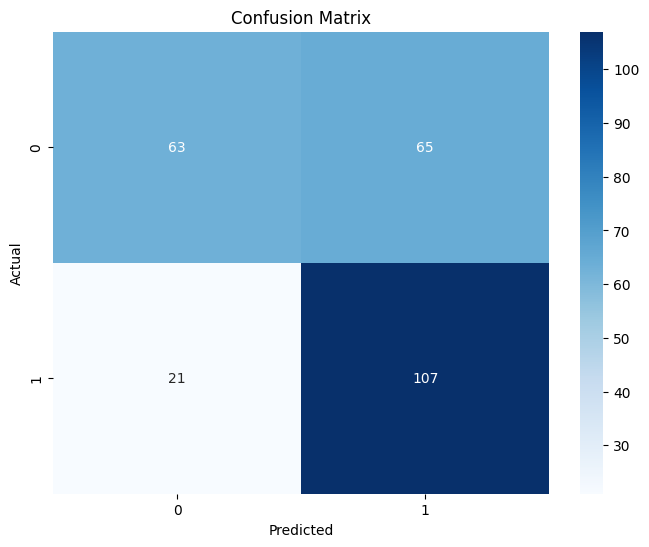

In [ ]:
#1
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
#2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#3
evaluate_model(model,train_dataloader, test_dataloader, device)

# Example of how to call the function
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = YourModel().to(device)
# train_dataloader = DataLoader(train_dataset, batch_size=32)
# test_dataloader = DataLoader(test_dataset, batch_size=32)
# evaluate_model(model, train_dataloader, test_dataloader, device)

# **For Train Model**

In [ ]:
model.train()
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# **For Testing 單一目標**

In [ ]:
def predict_audio(audio_path, seconds_per_segment=1):
    # 加載音頻文件
    waveform, sample_rate = librosa.load(audio_path, sr=16000)  # 確保與訓練數據使用相同的采樣率

    # 設定每個片段的樣本數
    num_samples_per_segment = sample_rate * seconds_per_segment
    total_samples = waveform.shape[0]
    predictions = []

    # 循環處理每五秒的音頻片段
    for start in range(0, total_samples, num_samples_per_segment):
        end = start + num_samples_per_segment
        segment = waveform[start:end]

        if len(segment) < num_samples_per_segment:
            break  # 如果音頻剩下的長度不足五秒，停止處理

        # 使用特徵提取器處理音頻
        inputs = feature_extractor(segment, sampling_rate=sample_rate, return_tensors="pt", padding="max_length", max_length=num_samples_per_segment, truncation=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # 確保將輸入數據轉移到模型所在的設備

        # 用模型進行預測
        with torch.no_grad():
            outputs = model(**inputs)

        # 取得最終預測結果
        pred_label = torch.argmax(outputs.logits, dim=-1)
        predictions.append(pred_label.item())  # 收集每5秒的預測結果

    return predictions  # 返回所有片段的預測結果

# 使用函數
audio_path = '/content/mix.wav'
predicted_labels = predict_audio(audio_path)
predicted_descriptions = ["f" if label == 0 else "r" for label in predicted_labels]
print("Predicted Labels per five seconds:", predicted_descriptions)


<ipython-input-41-090dab74037e>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(audio_path, sr=16000)  # 確保與訓練數據使用相同的采樣率
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Predicted Labels per five seconds: ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r', 'r', 'r', 'f', 'r', 'r', 'r']


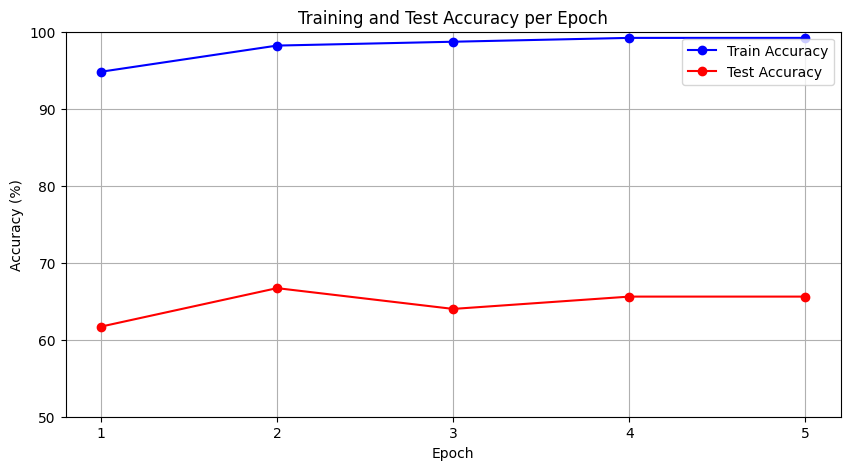

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_trends(train_acc, test_acc, epochs):
    """
    Plots training and test accuracy trends over epochs with specified y-axis limits.

    Parameters:
    - train_acc: List of training accuracies.
    - test_acc: List of testing accuracies.
    - epochs: List of epoch numbers.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='o', color='red')
    plt.title('Training and Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)  # Ensure all epoch markers are shown
    plt.ylim(50, 100)  # Adjusted for the given accuracy ranges
    plt.legend()
    plt.grid(True)
    plt.show()

# Extracted accuracies from your provided data
train_accuracy = [94.8, 98.2, 98.7, 99.2, 99.2]  # Convert to percentages
test_accuracy = [61.7, 66.7, 64.0, 65.6, 65.6]  # Convert to percentages
epochs = [1, 2, 3, 4, 5]

plot_accuracy_trends(train_accuracy, test_accuracy, epochs)

